In [3]:
import pandas as pd
import numpy as np
import re
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Sequential
from keras.layers import Dense
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import json

In [4]:
train_df = pd.read_csv('ReviewsTraining.csv')
test_df = pd.read_csv('ReviewsTest.csv')

# Text Cleaning (Expand Contractions, Lowercasing, Removing Punctuation, Stopwords)
with open("contractions.txt", "r", encoding="utf-8") as f:
    contractions_data = f.read()

contractions = json.loads(contractions_data.split("CONTRACTION_MAP = ")[-1])

def expand_contraction(text, contractions_dict):
  for contraction, expanded in contractions_dict.items():
    text = re.sub(contraction, expanded, text)
  return text

def preprocess_text(text):
  text = text.lower()
  text = expand_contraction(text, contractions)
  text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
  return text

print(train_df.columns)

import nltk
nltk.download('stopwords')
nltk.download('wordnet')

from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
stop_words.difference_update({"not", "no", "never", "none", "nothing", "nowhere", "hardly", "scarcely", "barely", "without", "against", "but", "too"})
print(stop_words)

from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    #Remove tags
    text = re.sub(r"<.*+>", " ", text)
    # Lowercasing
    text = text.lower()
    #Tokenization
    tokens = text.split()
    # Removing punctuation and special characters
    tokens = [re.sub(r"[^a-zA-Z\s]", "", word) for word in tokens]
    # Removing stopwords
    tokens = [word for word in tokens if word not in stop_words]
    # Lemmatization (Step 1.5)
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    # filter out short words
    tokens = [word for word in tokens if len(word) > 1]
    # Removing extra whitespaces (Step 1.6)
    text = " ".join(tokens)
    return text.strip()

# Apply text cleaning
train_df["processed_text"] = train_df["Summary"].astype(str) + " " + train_df["Text"].astype(str)
train_df["processed_text"] = train_df["processed_text"].apply(preprocess_text)
train_df["processed_text"] = train_df["processed_text"].apply(clean_text)

Index(['ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')


[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1006)>
[nltk_data] Error loading wordnet: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1006)>


{'this', "i'd", 'more', 'most', 'who', 'won', 'aren', "we're", 't', 'hasn', 'while', 'yours', 'that', 'yourselves', "haven't", 'until', "aren't", "she's", "needn't", 'am', 'an', 'under', 'myself', "weren't", 'their', 'having', "it'll", 'do', 'itself', 'some', 'ours', 'down', 'a', 'been', "wouldn't", 'through', 'why', "it'd", 'being', 'has', 'shouldn', 'ain', 'theirs', 'd', 'which', 'once', "you'll", 'it', 'how', 'mightn', 'here', 're', "won't", 'during', "you've", 'did', 'couldn', "they've", 'below', 'isn', "that'll", 'be', 'because', 'm', 'where', 'wasn', 'what', 'him', 'such', 'there', 'mustn', 'all', 'after', "she'll", "we'll", 'other', 'hadn', 'was', 'any', 'himself', 'can', 'further', 'you', 'were', 'nor', 'in', "you'd", 'the', 'before', 'are', 'these', "it's", 'have', "they'll", 'each', 'me', 'by', 'or', 'its', 'those', "they're", 'they', 'doesn', 'had', 'is', 'doing', 've', 'over', "shan't", "you're", 'than', 'them', 'then', 'we', 'our', 'haven', "wasn't", 'needn', 'my', 'so', "

      aa  aa sumatra  aahhhs  aahhhs get  aand  aand filter  aback  \
0      0           0       0           0     0            0      0   
1      0           0       0           0     0            0      0   
2      0           0       0           0     0            0      0   
3      0           0       0           0     0            0      0   
4      0           0       0           0     0            0      0   
...   ..         ...     ...         ...   ...          ...    ...   
4995   0           0       0           0     0            0      0   
4996   0           0       0           0     0            0      0   
4997   0           0       0           0     0            0      0   
4998   0           0       0           0     0            0      0   
4999   0           0       0           0     0            0      0   

      aback brand  abandon  abates  ...  zucchini garbanzo  zucchini organic  \
0               0        0       0  ...                  0                 0   

/Users/aaronsu/Library/Python/3.11/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
479/500 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7843 - loss: 0.4739
Epoch 1: val_accuracy improved from -inf to 0.86700, saving model to best_model.h1.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7860 - loss: 0.4709 - val_accuracy: 0.8670 - val_loss: 0.3296
Epoch 2/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9164 - loss: 0.2374
Epoch 2: val_accuracy improved from 0.86700 to 0.88000, saving model to best_model.h1.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9163 - loss: 0.2375 - val_accuracy: 0.8800 - val_loss: 0.3237
Epoch 3/100
489/500 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9326 - loss: 0.1821
Epoch 3: val_accuracy did not improve from 0.88000
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9324 - loss: 0.1823 - val_accuracy: 0.8730 - val_loss: 0.3441
Epoch 4/100
483/500 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9445 - loss: 0.1445
Epoch 4: val_accuracy did not improve from 0.88000
500/500 ━━━━━━━━━━

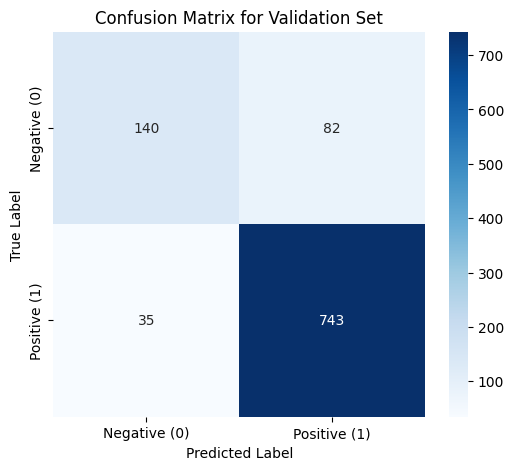

In [5]:
#n-grams comparison
bv = CountVectorizer(ngram_range=(1,2))
bv_matrix = bv.fit_transform(train_df["processed_text"])
bv_matrix = bv_matrix.toarray()
vocab = bv.get_feature_names_out()
print(pd.DataFrame(bv_matrix, columns=vocab))

#Categorize to Positive and Negative Reviews
train_df["label"] = train_df["Score"].apply(lambda x: 1 if x >= 4 else 0)


#Prediction model using single word tokens
#Tokenize texts
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_df["processed_text"])
X = tokenizer.texts_to_matrix(train_df["processed_text"])
y = train_df["label"].values

#Train Validation Split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10)
n_words = X_train.shape[1]

model = Sequential()
model.add(Dense(50, input_shape=(n_words,), activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
checkpoint = ModelCheckpoint("best_model.h1.keras", monitor="val_accuracy", save_best_only=True, mode="max", verbose=1)
early_stopping = EarlyStopping(monitor="val_accuracy", patience=10, restore_best_weights=True, mode="max", verbose=1)
model.fit(X_train, y_train, epochs=100, batch_size=8, validation_data=(X_val, y_val), callbacks=[checkpoint, early_stopping])

print(f"Highest Validation Accuracy Achieved: {max(model.history.history['val_accuracy'])}")

# Get validation predictions
val_predictions = (model.predict(X_val) > 0.5).astype(int).flatten()

# Compute confusion matrix
cm = confusion_matrix(y_val, val_predictions)

# Plot the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative (0)", "Positive (1)"], yticklabels=["Negative (0)", "Positive (1)"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Validation Set")
plt.show()

In [6]:
#Identify words contributing most to negative review predictions
# Extract the first dense layer's weights
weights = model.layers[0].get_weights()[0]
# Compute the importance of words for negative classification
word_importance = np.mean(weights, axis=1)
# Get word index mapping
word2index = tokenizer.word_index
index2word = {v: k for k, v in word2index.items()}
# Get words with lowest importance (negative reviews)
negative_word_indices = np.argsort(word_importance)[:20]  # Adjust number as needed
negative_words = [(index2word[i+1], word_importance[i]) for i in negative_word_indices]
# Convert to DataFrame for better visualization
negative_words_df = pd.DataFrame(negative_words, columns=['Word', 'Weight'])
print(negative_words_df)

         Word    Weight
0         but -0.049921
1          br -0.049674
2     machine -0.049141
3        good -0.041878
4        tiny -0.032181
5        must -0.030234
6     thought -0.028670
7      animal -0.024205
8      ginger -0.024160
9      broken -0.023973
10         mg -0.022529
11   category -0.021418
12       york -0.019370
13     flavor -0.018732
14      stuff -0.018352
15  shortcake -0.018267
16      breed -0.018224
17     filled -0.017339
18       dirt -0.017070
19       bake -0.017028


/Users/aaronsu/Library/Python/3.11/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
496/500 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7704 - loss: 0.5596
Epoch 1: val_accuracy improved from -inf to 0.81100, saving model to best_model.h2.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.7705 - loss: 0.5589 - val_accuracy: 0.8110 - val_loss: 0.4288
Epoch 2/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9487 - loss: 0.1797
Epoch 2: val_accuracy improved from 0.81100 to 0.84500, saving model to best_model.h2.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.9487 - loss: 0.1796 - val_accuracy: 0.8450 - val_loss: 0.4232
Epoch 3/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9919 - loss: 0.0430
Epoch 3: val_accuracy improved from 0.84500 to 0.84600, saving model to best_model.h2.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.9919 - loss: 0.0430 - val_accuracy: 0.8460 - val_loss: 0.4489
Epoch 4/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9966 - loss: 0.0148
Epoch 4: val_accuracy

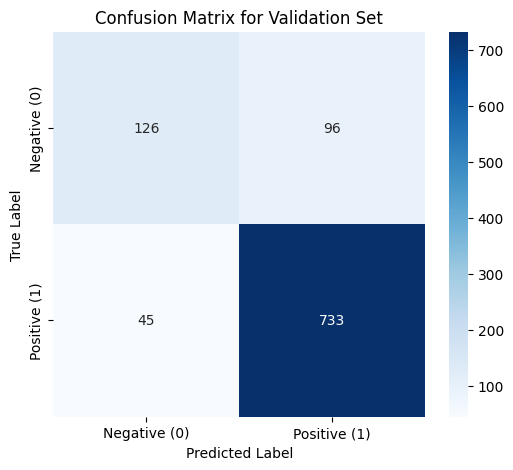

In [7]:
#Prediction Model using Bigrams
def generate_ngrams(text, n):
    tokens = text.split()  # Tokenize by space
    ngrams = [' '.join(tokens[i:i+n]) for i in range(len(tokens)-n+1)]
    return ngrams

ngram_texts = ['-'.join(generate_ngrams(text, 2)) for text in train_df["processed_text"]]
tokenizer2 = Tokenizer(split='-')
tokenizer2.fit_on_texts(ngram_texts)
X2 = tokenizer2.texts_to_matrix(ngram_texts)
y2 = train_df["label"].values

#Train Validation Split
X_train2, X_val2, y_train2, y_val2 = train_test_split(X2, y2, test_size=0.2, random_state=10)
n_words = X_train2.shape[1]

model2 = Sequential()
model2.add(Dense(50, input_shape=(n_words,), activation='relu'))
model2.add(Dense(1, activation='sigmoid'))

model2.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
checkpoint = ModelCheckpoint("best_model.h2.keras", monitor="val_accuracy", save_best_only=True, mode="max", verbose=1)
early_stopping = EarlyStopping(monitor="val_accuracy", patience=10, restore_best_weights=True, mode="max", verbose=1)
model2.fit(X_train2, y_train2, epochs=100, batch_size=8, validation_data=(X_val2, y_val2), callbacks=[checkpoint, early_stopping])

print(f"Highest Validation Accuracy Achieved: {max(model2.history.history['val_accuracy'])}")

# Get validation predictions
val_predictions2 = (model2.predict(X_val2) > 0.5).astype(int).flatten()

# Compute confusion matrix
cm = confusion_matrix(y_val2, val_predictions2)

# Plot the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative (0)", "Positive (1)"], yticklabels=["Negative (0)", "Positive (1)"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Validation Set")
plt.show()

In [8]:
#Identify phrases contributing most to negative review predictions
# Extract the first dense layer's weights
weights = model2.layers[0].get_weights()[0]
# Compute the importance of words for negative classification
phrase_importance = np.mean(weights, axis=1)
# Get word index mapping
phrase2index = tokenizer2.word_index
index2phrase = {v: k for k, v in phrase2index.items()}
# Get words with lowest importance (negative reviews)
negative_phrase_indices = np.argsort(phrase_importance)[:20]  # Adjust number as needed
negative_phrases = [(index2phrase[i+1], phrase_importance[i]) for i in negative_phrase_indices]
# Convert to DataFrame for better visualization
negative_phrases_df = pd.DataFrame(negative_phrases, columns=['Phrase', 'Weight'])
print(negative_phrases_df)

                  Phrase    Weight
0         rich chocolate -0.006561
1              but grove -0.006560
2   tonguepuckering tang -0.006448
3          waffle freeze -0.006375
4              chip open -0.006323
5        aftertaste plan -0.006115
6            taste burnt -0.006022
7             best spicy -0.005981
8           br recommend -0.005923
9        something drink -0.005906
10         amazon review -0.005857
11             buy brand -0.005687
12          flavor right -0.005648
13        many different -0.005609
14             smell too -0.005540
15        extract powder -0.005535
16              one said -0.005517
17            sour cream -0.005506
18         listed amazon -0.005403
19            could find -0.005307


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Test Accuracy of single word tokenizer: 0.8440


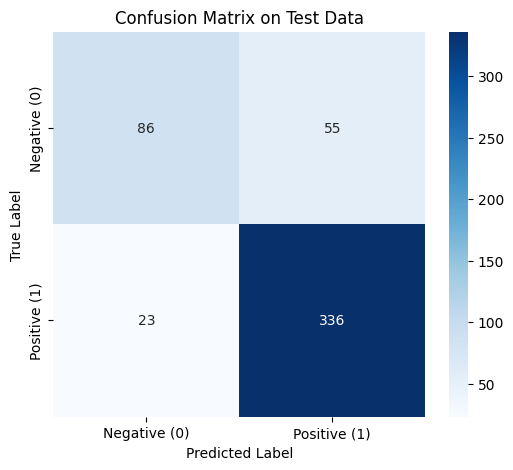

Predictions saved successfully!
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Test Accuracy of Bigram tokenizer: 0.7980


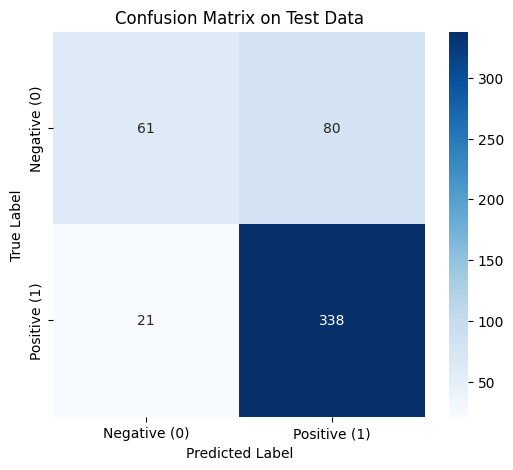

In [9]:
#Predict using test set
test_df["cleaned_text"] = test_df["Summary"].astype(str) + " " + test_df["Text"].astype(str)
test_df["cleaned_text"] = test_df["cleaned_text"].apply(clean_text)

X_test = tokenizer.texts_to_matrix(test_df["cleaned_text"])

ngram_test_texts = ['-'.join(generate_ngrams(text, 2)) for text in test_df["cleaned_text"]]
X_test2 = tokenizer2.texts_to_matrix(ngram_test_texts)

# Predict using the best model
best_model1 = keras.models.load_model("best_model.h1.keras")
best_model2 = keras.models.load_model("best_model.h2.keras")

test_predictions1 = (best_model1.predict(X_test) > 0.5).astype(int).flatten()

# Assign labels to the test data (1 = positive review, 0 = negative review)
test_df["label"] = test_df["Score"].apply(lambda x: 1 if x >= 4 else 0)

# Compute accuracy on test data
test_accuracy = accuracy_score(test_df["label"], test_predictions1)
print(f"Test Accuracy of single word tokenizer: {test_accuracy:.4f}")

# Generate confusion matrix
cm = confusion_matrix(test_df["label"], test_predictions1)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative (0)", "Positive (1)"], yticklabels=["Negative (0)", "Positive (1)"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix on Test Data")
plt.show()

# Save predictions
np.savetxt("Team10_predictions.txt", test_predictions1, fmt='%d')
print("Predictions saved successfully!")

test_predictions2 = (best_model2.predict(X_test2) > 0.5).astype(int).flatten()

# Compute accuracy on test data
test_accuracy = accuracy_score(test_df["label"], test_predictions2)
print(f"Test Accuracy of Bigram tokenizer: {test_accuracy:.4f}")

# Generate confusion matrix
cm = confusion_matrix(test_df["label"], test_predictions2)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative (0)", "Positive (1)"], yticklabels=["Negative (0)", "Positive (1)"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix on Test Data")
plt.show()

# # Save predictions
# np.savetxt("Team10_predictions2.txt", test_predictions2, fmt='%d')
# print("Predictions saved successfully!")

In [10]:
# Identify Recurring Words through counting
# Assuming train_df contains the review texts and labels
negative_reviews = train_df[train_df['label'] == 0]['processed_text']
# Tokenize the negative reviews
tokenizer = Tokenizer()
tokenizer.fit_on_texts(negative_reviews)

from collections import Counter
# Convert texts to sequences
word_counts = Counter()
for text in negative_reviews:
    word_counts.update(text.split())
# Get the most common words
most_common_words = word_counts.most_common(20)  # Adjust the number as needed
# Convert to DataFrame for better visualization
common_words_df = pd.DataFrame(most_common_words, columns=['Word', 'Frequency'])

# Identify Phrases through counting n-grams
from nltk.util import ngrams
nltk.download('punkt_tab')
# Tokenize and extract n-grams (adjust n for bigrams, trigrams, etc.)
def get_ngrams(text_series, n):
    all_ngrams = []
    for text in text_series:
        tokens = nltk.word_tokenize(text)  # Tokenize each review
        n_grams = list(ngrams(tokens, n))  # Extract n-grams
        all_ngrams.extend(n_grams)  # Collect all n-grams
    return all_ngrams

# n=2 for bigrams
bigrams_list = get_ngrams(negative_reviews, 2)
# Count occurrences of each n-gram
bigram_counts = Counter(bigrams_list)
# Get the most common 2-grams
most_common_bigrams = bigram_counts.most_common(20)  # Adjust the number as needed
# Convert to readable format
common_phrases_n2 = pd.DataFrame(most_common_bigrams, columns=['Bigram', 'Frequency'])
common_phrases_n2['Bigram'] = common_phrases_n2['Bigram'].apply(lambda x: " ".join(x))

# n=3 for trigrams
trigrams_list = get_ngrams(negative_reviews, 3)
# Count occurrences of each n-gram
trigram_counts = Counter(trigrams_list)
# Get the most common 3-grams
most_common_trigrams = trigram_counts.most_common(20)  # Adjust the number as needed
# Convert to readable format
common_phrases_n3 = pd.DataFrame(most_common_trigrams, columns=['Trigram', 'Frequency'])
common_phrases_n3['Trigram'] = common_phrases_n3['Trigram'].apply(lambda x: " ".join(x))

# Display results
common_phrases = pd.concat([common_words_df, common_phrases_n2, common_phrases_n3], axis=1)
print(pd.DataFrame.from_dict(common_phrases))

[nltk_data] Error loading punkt_tab: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1006)>


       Word  Frequency         Bigram  Frequency              Trigram  \
0       not       2067        but not        182      not waste money   
1       but       1026        can not        119          not bad but   
2        br        707     taste like         82  local grocery store   
3      like        635       not good         81          but can not   
4     taste        598      would not         79         good but not   
5   product        520        not buy         63       not taste good   
6     would        462      could not         60      can not believe   
7    flavor        428       not like         54        would not buy   
8      good        422       too much         44       not taste like   
9       one        405        not bad         44   high fructose corn   
10     food        307      not taste         44  would not recommend   
11     chip        302      hot cocoa         40  fructose corn syrup   
12       no        281  hot chocolate         40   

In [ ]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD

train_df["label"] = train_df["Score"] - 1 #Labels set to 0-4 from 1-5
y = to_categorical(train_df["label"], num_classes=5) 

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10)

n_words = X_train.shape[1]  # Correctly set feature count

multi_class_model = Sequential()
multi_class_model.add(Dense(50, input_shape=(n_words,), activation='relu'))
multi_class_model.add(Dense(32, activation='relu'))
multi_class_model.add(Dense(5, activation='softmax')) 

multi_class_model.compile(loss='categorical_crossentropy', optimizer= SGD(learning_rate=0.01, momentum=0.9), metrics=['accuracy'])
checkpoint = ModelCheckpoint("best_multiclass_model.keras", monitor="val_accuracy", save_best_only=True, mode="max", verbose=1)
early_stopping = EarlyStopping(monitor="val_accuracy", patience=10, restore_best_weights=True, mode="max", verbose=1)
multi_class_model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_val, y_val), callbacks=[checkpoint, early_stopping])

print(f"Highest Validation Accuracy Achieved: {max(multi_class_model.history.history['val_accuracy'])}")

/Users/aaronsu/Library/Python/3.11/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
192/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5866 - loss: 1.2420
Epoch 1: val_accuracy improved from -inf to 0.66500, saving model to best_multiclass_model.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5935 - loss: 1.2015 - val_accuracy: 0.6650 - val_loss: 0.8946
Epoch 2/50
200/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6981 - loss: 0.7751
Epoch 2: val_accuracy improved from 0.66500 to 0.71300, saving model to best_multiclass_model.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7000 - loss: 0.7731 - val_accuracy: 0.7130 - val_loss: 0.8224
Epoch 3/50
226/250 ━━━━━━━━━━━━━━━━━━━━ 0s 898us/step - accuracy: 0.7952 - loss: 0.5765
Epoch 3: val_accuracy did not improve from 0.71300
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7945 - loss: 0.5769 - val_accuracy: 0.6850 - val_loss: 0.8990
Epoch 4/50
217/250 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step - accuracy: 0.8570 - loss: 0.3994
Epoch 4: val_accuracy did not improve from 0.71300
25

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Test Accuracy of Bonus: 0.6600


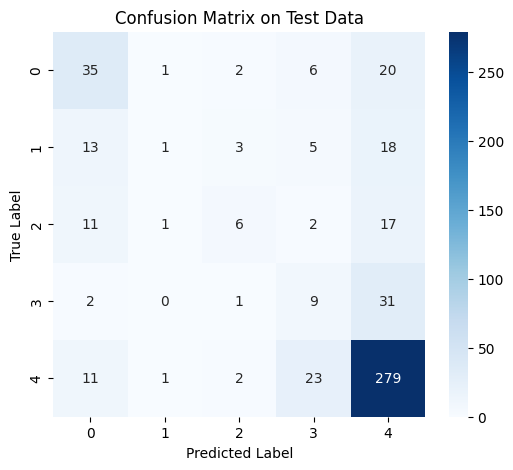

In [ ]:
bonus_model = keras.models.load_model("best_multiclass_model.keras")
bonus_predictions = bonus_model.predict(X_test).argmax(axis=1)
test_df["label"] = test_df["Score"] - 1  # Now labels are 0-4, not 1-5

np.savetxt("Team10_predictions_bonus.txt", bonus_predictions, fmt='%d')

test_accuracy = accuracy_score(test_df["label"], bonus_predictions)
print(f"Test Accuracy of Bonus: {test_accuracy:.4f}")

cm = confusion_matrix(test_df["label"], bonus_predictions)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix on Test Data")
plt.show()